In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from soundfile import SoundFile
import pandas as pd
from IPython.display import Audio
from pathlib import Path

import matplotlib.pyplot as plt

import joblib, json, re
import noisereduce as nr

In [2]:
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings('ignore')

In [3]:
PATH = r'C:\Users\chase\Desktop\Georgia Tech\CSE 6740\Project\BIRDCLEF'

## Import Data

In [8]:
df = pd.read_csv(fr'{PATH}\filtered_data_with_labels 1.csv').drop(columns = 'y')
df["filename"] = df["filename"] .str.split('/').apply(lambda x: '/'.join(x[-2:]))
df.index = df["filename"]
df.head()

,primary_label,type,latitude,longitude,rating,filename
filename,,,,,,
asbfly/XC134896.ogg,asbfly,['call'],39.2297,118.1987,5.0,asbfly/XC134896.ogg
asbfly/XC207738.ogg,asbfly,['call'],21.1697,70.6005,4.0,asbfly/XC207738.ogg
asbfly/XC209218.ogg,asbfly,['call'],15.5442,73.7733,4.0,asbfly/XC209218.ogg
asbfly/XC209219.ogg,asbfly,['call'],15.5442,73.7733,4.0,asbfly/XC209219.ogg
asbfly/XC267680.ogg,asbfly,"['call', 'male', 'song']",44.3602,132.7989,4.0,asbfly/XC267680.ogg


In [10]:
len(df.columns)

6

In [12]:
len(df)

9310

In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['primary_label'], random_state=42)

master = pd.read_csv(f"{PATH}/master.csv").iloc[:,1:]
master.index = master["filename"]
df_train = master.loc[df_train.index].reset_index(drop = True)
df_test = master.loc[df_test.index].reset_index(drop = True)

print(len(df_train['primary_label'].unique()), len(df_train['primary_label'].unique()))
print(len(df_train), len(df_test))

89 89
7448 1862


In [15]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df["primary_label"])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train["primary_label"])
class_weight_dict = dict(zip(classes, class_weights))
 
print("Class Frequencies:", pd.Series(df_train["primary_label"]).value_counts().to_dict())
print("\nClass Weights:", class_weight_dict)

Class Frequencies: {'comkin1': 246, 'eurcoo': 230, 'graher1': 222, 'bkwsti': 222, 'commoo3': 216, 'bcnher': 215, 'rorpar': 209, 'litegr': 198, 'comgre': 198, 'grnsan': 198, 'comsan': 197, 'eaywag1': 196, 'barswa': 182, 'woosan': 180, 'lirplo': 179, 'houspa': 169, 'litgre1': 162, 'greegr': 155, 'grywag': 150, 'zitcis1': 120, 'wemhar1': 119, 'labcro1': 114, 'blakit1': 107, 'bkskit1': 104, 'purher1': 98, 'grtdro1': 96, 'whiter2': 89, 'grewar3': 87, 'hoopoe': 86, 'rerswa1': 84, 'commyn': 83, 'categr': 83, 'comtai1': 83, 'kenplo1': 78, 'eucdov': 76, 'houcro1': 75, 'comros': 69, 'crseag1': 67, 'asikoe2': 66, 'comior1': 63, 'rewlap1': 63, 'whtkin2': 62, 'ruftre2': 58, 'piekin1': 56, 'brnshr': 54, 'blhori1': 53, 'stbkin1': 53, 'blnmon1': 52, 'whbwat1': 50, 'gargan': 50, 'shikra1': 49, 'nutman': 49, 'rewbul': 48, 'litspi1': 47, 'putbab1': 44, 'rocpig': 43, 'gyhcaf1': 42, 'grnwar1': 42, 'grbeat1': 39, 'pursun4': 39, 'whbwoo2': 38, 'gloibi': 38, 'copbar1': 38, 'litswi1': 38, 'revbul': 38, 'brnhao

In [18]:
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [20]:
print(df_train.primary_label.value_counts())
print(df_test.primary_label.value_counts())

primary_label
comkin1    246
eurcoo     230
graher1    222
bkwsti     222
commoo3    216
          ... 
oripip1     25
junowl1     24
asbfly      22
grejun2     22
gryfra      22
Name: count, Length: 89, dtype: int64
primary_label
comkin1    62
eurcoo     58
bkwsti     55
graher1    55
commoo3    54
           ..
insbab1     6
junowl1     6
oripip1     6
tibfly3     6
grejun2     5
Name: count, Length: 89, dtype: int64


In [22]:
df_train.to_csv(f"{PATH}/df_train.csv", index = False)
df_test.to_csv(f"{PATH}/df_test.csv", index = False)

## Training

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

In [27]:
# class Config:
#     use_aug = False
#     num_classes = len(df_train.primary_label.unique())
#     batch_size = 64
#     epochs = 10
#     PRECISION = 16    
#     PATIENCE = 8    
#     seed = 42
#     model = "tf_efficientnet_b0_ns"
#     pretrained = True            
#     weight_decay = 1e-3
#     use_mixup = True
#     mixup_alpha = 0.2   
#     DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

#     train_images = PATH+"/spectrogram/"
#     test_images = PATH + "/spectrogram/"
#     train_path = PATH+"/df_train.csv"
#     test_path = PATH+"/df_test.csv"
    
    
#     SR = 32000
#     DURATION = 10
#     MAX_READ_SAMPLES = 5
#     LR = 5e-4

In [29]:
from config import Config
from dataset import BirdDataset

In [30]:
pl.seed_everything(Config.seed, workers=True)

Seed set to 42


42

In [31]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [32]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)
df_train = pd.concat([df_train, pd.get_dummies(df_train['primary_label'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['primary_label'])], axis=1)

In [33]:
birds = list(df_train.primary_label.unique())

In [34]:
# class BirdDataset(torch.utils.data.Dataset):

#     def __init__(self, df, sr = Config.SR, duration = Config.DURATION, augmentations = None, train = True):

#         self.df = df
#         self.sr = sr 
#         self.train = train
#         self.duration = duration
#         self.augmentations = augmentations
#         if train:
#             self.img_dir = Config.train_images
#         else:
#             self.img_dir = Config.test_images

#     def __len__(self):
#         return len(self.df)

#     @staticmethod
#     def normalize(image):
#         image = image / 255.0
#         #image = torch.stack([image, image, image])
#         return image

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         impath = self.img_dir + f"{row.filename}.npy"

#         image = np.load(str(impath))[:Config.MAX_READ_SAMPLES]
        
#         ########## RANDOM SAMPLING ################
#         if self.train:
#             image = image[np.random.choice(len(image))]
#         else:
#             image = image[0]
            
#         #####################################################################
        
#         image = torch.tensor(image).float()

#         if self.augmentations:
#             image = self.augmentations(image.unsqueeze(0)).squeeze()
            
#         image.size()
        
#         image = torch.stack([image, image, image])

#         image = self.normalize(image)


#         return image, torch.tensor(row[16:]).float()

In [35]:
def get_fold_dls(df_train, df_test):

    ds_train = BirdDataset(
        df_train, 
        sr = Config.SR,
        duration = Config.DURATION,
        train = True
    )
    ds_test = BirdDataset(
        df_test, 
        sr = Config.SR,
        duration = Config.DURATION,
        train = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_test = DataLoader(ds_test, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_test, ds_train, ds_test

In [36]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

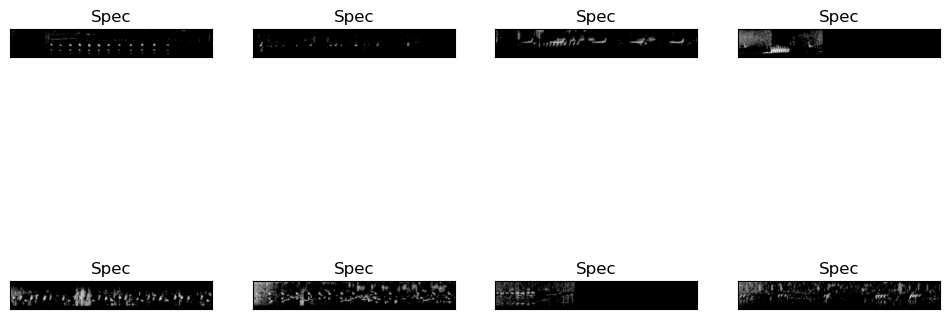

In [37]:
dl_train, dl_test, ds_train, ds_test = get_fold_dls(df_train, df_test)
show_batch(ds_test, 8, 2, 4)

In [40]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [47]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

In [48]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [49]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
    
        self.loss_function = nn.CrossEntropyLoss(weight=class_weights) 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        if batch_idx == 0:
            self._logits = []
            self._targets = []
            self._val_loss = []

        self._logits.append(outputs["logits"])
        self._targets.append(outputs["targets"])
        self._val_loss.append(outputs["val_loss"])

    def on_validation_epoch_end(self):
        output_val = torch.cat(self._logits, dim=0).cpu().detach().numpy()
        target_val = torch.cat(self._targets, dim=0).cpu().detach().numpy()
        avg_loss = torch.stack(self._val_loss).mean()

        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        # avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        # avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)

        if len(target_val.shape) > 1:
            target_val = np.argmax(target_val, axis=1)

        output_val = np.argmax(output_val, axis=1)
        avg_score3 = sklearn.metrics.accuracy_score(target_val,output_val)
        avg_score4 = sklearn.metrics.f1_score(target_val, output_val, average = 'weighted')
        
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        # print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        # print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation accuracy score {avg_score3}')
        print(f'epoch {self.current_epoch} validation F1 score {avg_score4}')
        
        return {'val_loss': avg_loss,'val_accuracy':avg_score3}

In [52]:
from pytorch_lightning.loggers import WandbLogger
import gc

def run_training():
    print(f"Running training...")
    logger = None
    
    dl_train, dl_test, ds_train, ds_test = get_fold_dls(df_train, df_test)
    
    audio_model = BirdClefModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= "exp1/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{Config.model}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        logger=logger,
        callbacks=callbacks_to_use,
        precision=Config.PRECISION, accelerator="gpu"
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_test)                

    gc.collect()

In [57]:
run_training()

Using 16bit Automatic Mixed Precision (AMP)


Running training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running trainer.fit



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | backbone      | EfficientNet     | 4.1 M  | train
1 | loss_function | CrossEntropyLoss | 0      | train
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.486    Total estimated model params size (MB)
339       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

epoch 0 validation loss 4.6808624267578125
epoch 0 validation accuracy score 0.015625
epoch 0 validation F1 score 0.002178485576923077


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 3.860
Epoch 0, global step 58: 'val_loss' reached 3.86014 (best 3.86014), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 0 validation loss 3.8638527393341064
epoch 0 validation accuracy score 0.2706766917293233
epoch 0 validation F1 score 0.21929333172457574


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 1.115 >= min_delta = 0.0. New best score: 2.745
Epoch 0, global step 116: 'val_loss' reached 2.74540 (best 2.74540), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 0 validation loss 2.752807140350342
epoch 0 validation accuracy score 0.50859291084855
epoch 0 validation F1 score 0.4719919114215763


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.435 >= min_delta = 0.0. New best score: 2.310
Epoch 1, global step 175: 'val_loss' reached 2.31033 (best 2.31033), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 1 validation loss 2.362027168273926
epoch 1 validation accuracy score 0.592373791621912
epoch 1 validation F1 score 0.5645293855052754


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.272 >= min_delta = 0.0. New best score: 2.038
Epoch 1, global step 233: 'val_loss' reached 2.03800 (best 2.03800), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 1 validation loss 2.0652756690979004
epoch 1 validation accuracy score 0.6396348012889366
epoch 1 validation F1 score 0.614948693501262


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 1.815
Epoch 2, global step 292: 'val_loss' reached 1.81546 (best 1.81546), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 2 validation loss 1.8366366624832153
epoch 2 validation accuracy score 0.6740064446831364
epoch 2 validation F1 score 0.6646288780653282


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.169 >= min_delta = 0.0. New best score: 1.646
Epoch 2, global step 350: 'val_loss' reached 1.64604 (best 1.64604), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 2 validation loss 1.6652833223342896
epoch 2 validation accuracy score 0.686358754027927
epoch 2 validation F1 score 0.6871723903786976


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 1.556
Epoch 3, global step 409: 'val_loss' reached 1.55606 (best 1.55606), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 3 validation loss 1.5937528610229492
epoch 3 validation accuracy score 0.7212674543501612
epoch 3 validation F1 score 0.7161404918994352


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.491
Epoch 3, global step 467: 'val_loss' reached 1.49064 (best 1.49064), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 3 validation loss 1.5173425674438477
epoch 3 validation accuracy score 0.7250268528464017
epoch 3 validation F1 score 0.7199148197456274


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.396
Epoch 4, global step 526: 'val_loss' reached 1.39589 (best 1.39589), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 4 validation loss 1.45952570438385
epoch 4 validation accuracy score 0.7422126745435016
epoch 4 validation F1 score 0.7378782584485218


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.337
Epoch 4, global step 584: 'val_loss' reached 1.33668 (best 1.33668), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 4 validation loss 1.382025957107544
epoch 4 validation accuracy score 0.7432867883995704
epoch 4 validation F1 score 0.7397046066690608


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.299
Epoch 5, global step 643: 'val_loss' reached 1.29867 (best 1.29867), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 5 validation loss 1.3454327583312988
epoch 5 validation accuracy score 0.7540279269602578
epoch 5 validation F1 score 0.7522435585712423


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.258
Epoch 5, global step 701: 'val_loss' reached 1.25757 (best 1.25757), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 5 validation loss 1.3100965023040771
epoch 5 validation accuracy score 0.757250268528464
epoch 5 validation F1 score 0.7564086790399392


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 760: 'val_loss' was not in top 1


epoch 6 validation loss 1.3265063762664795
epoch 6 validation accuracy score 0.7744360902255639
epoch 6 validation F1 score 0.7716612057138913


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.248
Epoch 6, global step 818: 'val_loss' reached 1.24830 (best 1.24830), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 6 validation loss 1.2625027894973755
epoch 6 validation accuracy score 0.7744360902255639
epoch 6 validation F1 score 0.7704826875059252


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.225
Epoch 7, global step 877: 'val_loss' reached 1.22477 (best 1.22477), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 7 validation loss 1.251800298690796
epoch 7 validation accuracy score 0.7755102040816326
epoch 7 validation F1 score 0.770881473373145


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 935: 'val_loss' was not in top 1


epoch 7 validation loss 1.2761391401290894
epoch 7 validation accuracy score 0.7712137486573577
epoch 7 validation F1 score 0.7664040473315934


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.221
Epoch 8, global step 994: 'val_loss' reached 1.22107 (best 1.22107), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 8 validation loss 1.278743028640747
epoch 8 validation accuracy score 0.7841031149301826
epoch 8 validation F1 score 0.780806338589174


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.209
Epoch 8, global step 1052: 'val_loss' reached 1.20854 (best 1.20854), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 8 validation loss 1.2291903495788574
epoch 8 validation accuracy score 0.7610096670247046
epoch 8 validation F1 score 0.7606715760975795


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 1.132
Epoch 9, global step 1111: 'val_loss' reached 1.13223 (best 1.13223), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 9 validation loss 1.1695811748504639
epoch 9 validation accuracy score 0.7841031149301826
epoch 9 validation F1 score 0.7827126584085363


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9, global step 1169: 'val_loss' was not in top 1


epoch 9 validation loss 1.236701250076294
epoch 9 validation accuracy score 0.784640171858217
epoch 9 validation F1 score 0.7810211541812341


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.127
Epoch 10, global step 1228: 'val_loss' reached 1.12679 (best 1.12679), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 10 validation loss 1.1789718866348267
epoch 10 validation accuracy score 0.7996777658431794
epoch 10 validation F1 score 0.7964638920140488


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10, global step 1286: 'val_loss' was not in top 1


epoch 10 validation loss 1.190858244895935
epoch 10 validation accuracy score 0.7943071965628357
epoch 10 validation F1 score 0.7900074635023125


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.093
Epoch 11, global step 1345: 'val_loss' reached 1.09288 (best 1.09288), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 11 validation loss 1.1529972553253174
epoch 11 validation accuracy score 0.7964554242749732
epoch 11 validation F1 score 0.7929236391671612


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.088
Epoch 11, global step 1403: 'val_loss' reached 1.08839 (best 1.08839), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 11 validation loss 1.1368777751922607
epoch 11 validation accuracy score 0.7975295381310419
epoch 11 validation F1 score 0.7970043708663084


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12, global step 1462: 'val_loss' was not in top 1


epoch 12 validation loss 1.1728739738464355
epoch 12 validation accuracy score 0.7969924812030075
epoch 12 validation F1 score 0.7932033753252873


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12, global step 1520: 'val_loss' was not in top 1


epoch 12 validation loss 1.1991636753082275
epoch 12 validation accuracy score 0.8050483351235231
epoch 12 validation F1 score 0.7998248647131461


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.044
Epoch 13, global step 1579: 'val_loss' reached 1.04442 (best 1.04442), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 13 validation loss 1.112978219985962
epoch 13 validation accuracy score 0.8120300751879699
epoch 13 validation F1 score 0.8087231539628437


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13, global step 1637: 'val_loss' was not in top 1


epoch 13 validation loss 1.1017473936080933
epoch 13 validation accuracy score 0.8120300751879699
epoch 13 validation F1 score 0.8082502821809681


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.041
Epoch 14, global step 1696: 'val_loss' reached 1.04135 (best 1.04135), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 14 validation loss 1.0902698040008545
epoch 14 validation accuracy score 0.8125671321160043
epoch 14 validation F1 score 0.8091316133725219


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.018
Epoch 14, global step 1754: 'val_loss' reached 1.01833 (best 1.01833), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 14 validation loss 1.0716780424118042
epoch 14 validation accuracy score 0.8163265306122449
epoch 14 validation F1 score 0.8124363051831316


Validation: |                                                                                    | 0/? [00:00<…

Epoch 15, global step 1813: 'val_loss' was not in top 1


epoch 15 validation loss 1.0816832780838013
epoch 15 validation accuracy score 0.8141783029001074
epoch 15 validation F1 score 0.8113039672586584


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.015
Epoch 15, global step 1871: 'val_loss' reached 1.01459 (best 1.01459), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 15 validation loss 1.0701115131378174
epoch 15 validation accuracy score 0.822234156820623
epoch 15 validation F1 score 0.8191505023238997


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16, global step 1930: 'val_loss' was not in top 1


epoch 16 validation loss 1.1000036001205444
epoch 16 validation accuracy score 0.8157894736842105
epoch 16 validation F1 score 0.8130289906161849


Validation: |                                                                                    | 0/? [00:00<…

Epoch 16, global step 1988: 'val_loss' was not in top 1


epoch 16 validation loss 1.0961980819702148
epoch 16 validation accuracy score 0.8141783029001074
epoch 16 validation F1 score 0.8108414950197157


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17, global step 2047: 'val_loss' was not in top 1


epoch 17 validation loss 1.1435927152633667
epoch 17 validation accuracy score 0.817937701396348
epoch 17 validation F1 score 0.8150888306216936


Validation: |                                                                                    | 0/? [00:00<…

Epoch 17, global step 2105: 'val_loss' was not in top 1


epoch 17 validation loss 1.0838598012924194
epoch 17 validation accuracy score 0.8227712137486574
epoch 17 validation F1 score 0.8200063441996313


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18, global step 2164: 'val_loss' was not in top 1


epoch 18 validation loss 1.1677006483078003
epoch 18 validation accuracy score 0.813641245972073
epoch 18 validation F1 score 0.8102470973832718


Validation: |                                                                                    | 0/? [00:00<…

Epoch 18, global step 2222: 'val_loss' was not in top 1


epoch 18 validation loss 1.0985251665115356
epoch 18 validation accuracy score 0.8200859291084855
epoch 18 validation F1 score 0.8171164883451626


Validation: |                                                                                    | 0/? [00:00<…

Epoch 19, global step 2281: 'val_loss' was not in top 1


epoch 19 validation loss 1.092903971672058
epoch 19 validation accuracy score 0.8195488721804511
epoch 19 validation F1 score 0.8165062984141246


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.995
Epoch 19, global step 2339: 'val_loss' reached 0.99489 (best 0.99489), saving model to 'C:\\Users\\chase\\Desktop\\Georgia Tech\\CSE 6740\\Project\\exp1\\./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 19 validation loss 1.056201696395874
epoch 19 validation accuracy score 0.8249194414607949
epoch 19 validation F1 score 0.8214762616273198


`Trainer.fit` stopped: `max_epochs=20` reached.
